<p style="font-size:20px">ELEC-E7851 - Computational User Interface Design<br></p>
<p style="font-size:30px"><b>Exercise 5 - Computational Modeling Workflow (5p)</b></p>

The number of points for this exercise is 5, but you can obtain bonus points in the last exercise. There are **two exercises** included in this sheet. Note that each exercise has **three sub-parts**. This notebook is structured as follows:

* Python setup
* Preparation: define functions
    * Model definitions
    * Forward simulation
    * Parameter recovery
    * Model comparison
* Exercise 1: Parameter recovery (2p)
* Exercise 2: Model comparison (3p+BONUS)

<div class="alert alert-block alert-danger">
Note that the exercise descriptions are provided <b>towards the end of this notebook</b>, as we provide some functions you may find useful in completing the exercises.
</div>

<div class="alert alert-block alert-info">
Additionally, remember the following guidelines:

<b>Reminder:</b> All assignments on this course are to be done on an individual basis. 

<b>Submission:</b> Submit as separate files: 1) Your report in PDF format and 2) your notebook in .ipynb format. Note that the .ipynb is not sufficient alone - even if you have documented it. We mainly  use the PDF for grading and .ipynb for quality assurance.

<b>Deadline</b> is given in MyCourses. Please observe it.
</div>

<h2><a class="tocSkip"></a>Python setup</h2>

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sys
import scipy
from itertools import product
import pandas as pd

from IPython.display import display, Math
%config InlineBackend.figure_format='retina'

In [7]:
# Define a folder for the bkp
BKP_FOLDER = "bkp"
DATA_FOLDER = "data"

# Create this folder if it doesn't exist
os.makedirs(BKP_FOLDER, exist_ok=True)

<h2><a class="tocSkip"></a>Preparation: define functions</h2>

While completing the exercise, you can use function definitions from the lecture. Some of these are included below. Note that model comparison is not included as it will be implemented as a part of the last exercise.

<h3><a class="tocSkip"></a>&nbsp;Model definitions</h3>

In [140]:
class GenericPlayer:
    
    """
    Generic Player
    """
    
    param_labels = ()
    fit_bounds = ()

    def __init__(self):
        self.options = np.arange(N)
        
    def decision_rule(self):
        raise NotImplementedError

    def learning_rule(self, option, success):
        raise NotImplementedError
        
    def choose(self):
        p = self.decision_rule()
        return np.random.choice(self.options, p=p)

In [76]:
class Random(GenericPlayer):
    
    """
    Random selection
    """

    def __init__(self):
        super().__init__()

    def decision_rule(self):
        return np.ones(N) / N
    
    def learning_rule(self, option, success):
        pass

In [77]:
class WSLS(GenericPlayer):
    """
    Win-Stay-Lose-Switch
    """

    param_labels = "epsilon",
    fit_bounds = (0., 1),

    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon

        self.c = -1
        self.r = -1

    def decision_rule(self):

        if self.c == -1:
            return np.ones(N) / N  # First turn

        p = np.zeros(N)

        p_apply_rule = 1 - self.epsilon # 1 - epsilon: apply the rule
        p_random = self.epsilon / N # epsilon: pick up randomly
        if self.r:
            p[self.options != self.c] = p_random
            p[self.c] = 1 - np.sum(p)  # p_apply_rule + p_random
        else:
            p[self.options != self.c] = p_apply_rule / (N - 1) + p_random
            p[self.c] = 1 - np.sum(p)  # p_random

        return p

    def learning_rule(self, option, success):
        self.r = success
        self.c = option

In [78]:
class RW(GenericPlayer):
    """
    Rescorla-Wagner
    """

    param_labels = r"$\alpha$", r"$\beta$",
    fit_bounds = (0.0, 1.0), (1.0, 20.0),

    def __init__(self, q_alpha, q_beta, initial_value=0.5):
        super().__init__()
        self.q_values = np.full(N, initial_value)
        self.q_alpha = q_alpha
        self.q_beta = q_beta

    def decision_rule(self):
        
        num = np.exp(self.q_beta * self.q_values)
        denom = np.sum(num)
        p_soft = num / denom
        return p_soft

    def learning_rule(self, option, success):
        err = success - self.q_values[option]
        self.q_values[option] += self.q_alpha * err 

<h3><a class="tocSkip"></a>&nbsp;Forward simulation</h3>

In [141]:
def run_simulation(model, param):

    # Create the agent
    agent = model(*param)

    # Data containers
    choices = np.zeros(T, dtype=int)
    successes = np.zeros(T, dtype=bool)

    # Simulate the task
    for t in range(T):

        # Determine choice
        choice = agent.choose()

        # Determine success
        success = P[choice] > np.random.random()

        # Make agent learn
        agent.learning_rule(option=choice, success=success)

        # Backup
        choices[t] = choice
        successes[t] = success

    return pd.DataFrame({
        "time": np.arange(T),
        "choice": choices, 
        "success": successes})

<h3><a class="tocSkip"></a>&nbsp;Parameter inference</h3>

In [131]:
def log_likelihood(model, param, data):

    # Create the agent
    agent = model(*param)

    # Data container
    ll = np.zeros(T)

    # Simulate the task
    for t in range(T):

        # Get choice and success for t
        c, s = data.choice[t], data.success[t]

        # Look at probability of choice
        p_choice = agent.decision_rule()
        p = p_choice[c]

        # Compute log
        ll[t] = np.log(p + np.finfo(float).eps)

        # Make agent learn
        agent.learning_rule(option=c, success=s)

    return np.sum(ll)

In [132]:
def objective(param, model, data):
    # Since we will look for the minimum, 
    # let's return -LLS instead of LLS
    return - log_likelihood(model=model,
                            data=data,
                            param=param)

def optimize(model, data):

    # Define an init guess
    init_guess = [(b[1] - b[0])/2 for b in model.fit_bounds]

    # Run the optimizer
    res = scipy.optimize.minimize(
        fun=objective,
        x0=init_guess,
        bounds=model.fit_bounds,
        args=(model, data))

    # Make sure that the optimizer ended up with success
    assert res.success

    # Get the best param and best value from the 
    best_param = res.x
    best_value = res.fun

    return best_param, best_value

<h3><a class="tocSkip"></a>&nbsp;Parameter recovery</h3>

In [142]:
def run_parameter_recovery(model, n_agents):
    
    # Data container
    row_list = []

    # For each agent...
    for i in tqdm(range(n), file=sys.stdout):

        # Generate parameters to simualte
        param_to_sim = [np.random.uniform(*b)
                        for b in model.fit_bounds]

        # Simulate
        d = run_simulation(model=model, param=param_to_sim)

        # Optimize
        best_param, best_value = optimize(model=model, data=d)

        # Backup
        for j in range(len(param_to_sim)):
            row_list.append({
                "Parameter": model.param_labels[j],
                "Used to simulate": param_to_sim[j],
                "Recovered": best_param[j]})
    
    df = pd.DataFrame(row_list)
    
    return df

In [134]:
def plot_parameter_recovery(model, df):
    
    # Plot
    param_names=model.param_labels
    param_bounds=model.fit_bounds
    n_param = len(param_names)

    # Define colors
    colors = [f'C{i}' for i in range(n_param)]

    # Create fig and axes
    fig, axes = plt.subplots(ncols=n_param,
                             figsize=(8, 8))

    for i in range(n_param):

        # Select ax
        if n_param > 1:
            ax = axes[i]
        else:
            ax = axes

        # Get param name
        p_name = param_names[i]

        # Set title
        ax.set_title(p_name)

        # Create scatter
        sns.scatterplot(data=df[df["Parameter"] == p_name], 
                        x="Used to simulate", y="Recovered", 
                        alpha=0.5, color=colors[i], 
                        ax=ax)

        # Plot identity function
        ax.plot(param_bounds[i], param_bounds[i], 
                linestyle="--", alpha=0.5, color="black", zorder=-10)

        # Set axes limits
        ax.set_xlim(*param_bounds[i])
        ax.set_ylim(*param_bounds[i])

        # Square aspect
        ax.set_aspect(1)

    plt.tight_layout()
    plt.show()

<h3><a class="tocSkip"></a>&nbsp;Model comparison</h3>

In [160]:
########INSERT THE CORRECT FUNCTIONS FROM LECTURE MATERIALS HERE########

Please refer to the lecture for the definition of these models. 

<h2><a class="tocSkip"></a>&nbsp;Exercise 1: Fine-tune an experiment (parameter recovery)</h2>


We are interested in modeling a player in a multi armed bandit task. Our hypothesis is that the player behaves according to one of the following models:
<li>Random
<li>Win-stay lose-switch
<li>Rescorla-Wagner 

The data for testing this hypothesis has not been collected yet. A colleague suggests that you use the following design for the task:

In [156]:
# Define the parameters of the bandit task

N = 3 # Number of options
P = np.array([0.11, 0.13, 0.12]) # Probability of different options
T = 10 # Number of trials

Where $N$ is the number of options, $P$ is a vector containing probabilities of a successful draw from each of the options and $T$ is the number of iterations. However, you notice that parameter recovery results for this task are very bad (using the same model definitions as in the lecture), when you consider Rescorla-Wagner and Win-stay lose-switch as models. Your task is to fine-tune the experiment to produce adequate parameter recovery results for these two models (visual inspection is enough). You may change any of $N$, $P$ or $T$ to re-design the task. Please report:

<p style="font-size:134x; padding-left: 120px; padding-right: 120px;text-align: left;line-height:150%;">
<ol type="A">
  <li>The values for $N$, $P$ and $T$ you chose to use.</li>
  <li>A plot of generating and recovered parameters for <b>both</b> Rescorla-Wagner and Win-stay lose-switch, with an interpretation.</li>
  <li>An explanation of why your proposition in (1) is an improvement upon the original task design.</li>
</ol>
</p>

The parameter recovery results are shown below for one model. You can use this code to answer the questions above.

In [150]:
if N == 3 and T==10 and (P==np.array([0.11, 0.13, 0.12])).all():
    print("----")
    print("STOP")
    print("----")
    print ("Please change the values for T, P and T.")

In [137]:
# Seed the pseudo-random number generator
np.random.seed(1284)

# Select one model
model = RW

# Define the number of agents to simulate
n = 30 

# Data container
row_list = []

df = run_parameter_recovery(model=model, n_agents = n)

# Create dataframe and save it
df.to_csv(os.path.join(BKP_FOLDER, "likelihood_explo.csv"))

100%|███████████████████████████████████████████| 30/30 [00:00<00:00, 36.34it/s]


In [138]:
# Load the dataframe and display it
df = pd.read_csv(os.path.join(BKP_FOLDER, "likelihood_explo.csv"), index_col=[0])
display(df.head())

,Parameter,Used to simulate,Recovered
0,$\alpha$,0.774765,0.392578
1,$\beta$,15.400237,20.000000
2,$\alpha$,0.040609,0.016336
3,$\beta$,18.269609,20.000000
4,$\alpha$,0.370267,0.197671


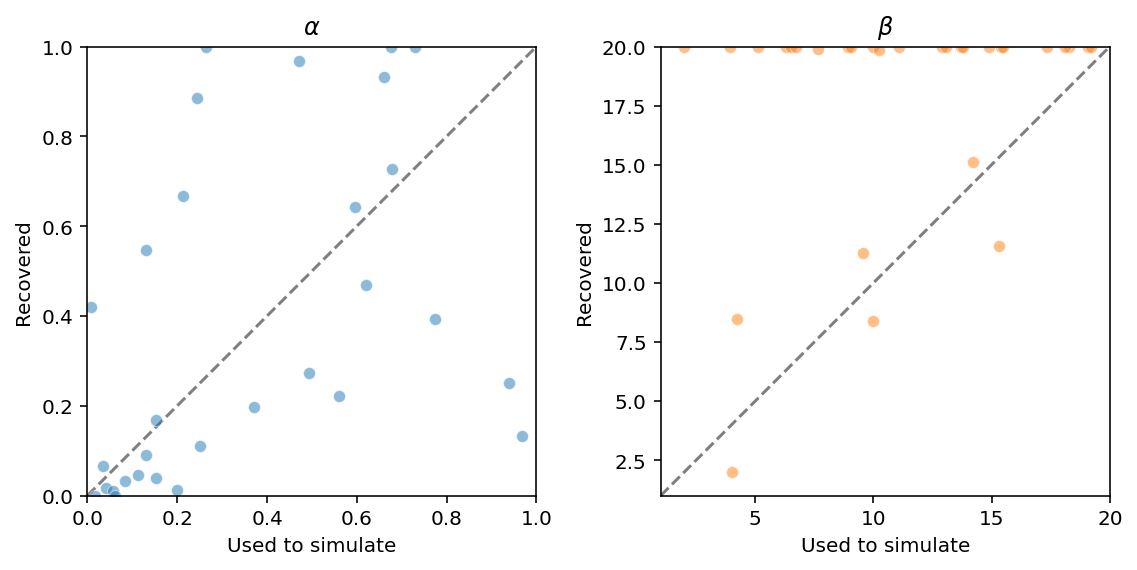

In [139]:
plot_parameter_recovery(model=model, df=df)

<font color="red"><i>Please provide your solution here</i></font>

In [162]:
########PROVIDE YOUR IMPLEMENTATION HERE########

<h2><a class="tocSkip"></a>&nbsp;Exercise 2: Build a computational model (model comparison)</h2>


We are still interested in modeling players in a multi armed bandit task. Our hypothesis is that one player behaves according to one of the following models:
<li>Random
<li>Win-stay lose-switch
<li>Rescorla-Wagner 

You are given data collected for a multi-armed bandit task with the following task design:

In [13]:
# Define the parameters of the bandit task

N = 4 # Number of options
P = np.array([0.12,0.89,0.88,0.10]) # Probability of different options
T = 400 # Number of trials

Please ensure that you have run the cell above before attempting exercise 2.

In [14]:
if N == 3 and T==10 and (P==np.array([0.11, 0.13, 0.12])).all():
    print("----")
    print("STOP")
    print("----")
    print ("Did you change the task definition from exercise 1?")
    
    raise(Exception)

The dataset includes observations from four individuals. Your task is to determine which model (Random, RW, WSLS) best describes each of the individuals as measured by a BIC score (note that they may behave according to different models). You may start with the models provided in the lecture. Please report:

<p style="font-size:134x; padding-left: 120px; padding-right: 120px;text-align: left;line-height:150%;">
<ol type="A">
  <li>The steps you used to obtain the results.</li>
  <li>The models that best describe each individual.</li>
  <li>An explanation of how you interpreted the BIC scores.</li>
</ol>
</p>

Let's first inspect the data:

In [16]:
# Load the data
bhv_data = pd.read_csv(os.path.join(DATA_FOLDER, "bhv_data.csv"), 
                         index_col=[0])
# Print...
display(bhv_data)

,time,choice,success,id
0,0,3,False,0
1,1,3,False,0
2,2,3,False,0
3,3,0,False,0
4,4,1,True,0
...,...,...,...,...
395,395,1,True,3
396,396,1,True,3
397,397,1,True,3
398,398,1,True,3


Please provide your solution below, indicating which steps you took. Note that you have to copy some code from the lecture.

<font color="red"><i>Provide your solution here</i></font>

In [17]:
########PROVIDE YOUR IMPLEMENTATION HERE########

<b>BONUS:</b> You may obtain bonus points if you can propose a model of your own that has a higher BIC score than the models presented in the lecture. 

In [18]:
########PROVIDE YOUR MODEL IMPLEMENTATION HERE (OPTIONAL)########
class CustomModel:
    pass